# Christopher Kramer
# Data Science Capstone - Final
# 2021-05-22

In January, 2014, the leaders of GAStech are celebrating their new-found fortune as a result of the initial public offering of their very successful company. In the midst of this celebration, several employees of GAStech go missing. An organization known as the Protectors of Kronos (POK) is suspected in the disappearance, but things may not be what they seem.

Many of the Abila, Kronos-based employees of GAStech have company cars which are approved for both personal and business use. Those who do not have company cars have the ability to check out company trucks for business use, but these trucks cannot be used for personal business. Employees with company cars are happy to have these vehicles, because the company cars are generally much higher quality than the cars they would be able to afford otherwise. However, GAStech does not trust their employees. Without the employees’ knowledge, GAStech has installed geospatial tracking software in the company vehicles. The vehicles are tracked periodically as long as they are moving.

This vehicle tracking data has been made available to law enforcement to support their investigation. Unfortunately, data is not available for the day the GAStech employees went missing. Data is only available for the two weeks prior to the disappearance. In addition to the vehicle data, law enforcement has been given access to the personal and business credit and debit card transactions for the local GAStech employees for the two weeks preceding the kidnapping. Many of the GAStech employees also use loyalty cards to gain discounts or extra benefits at the businesses they patronize, and law enforcement has been given access to two weeks of this loyalty card data as well.

As a data scientist expert assisting law enforcement, your mission is to make sense of this data to identify suspicious patterns of behavior and to prioritize which of these may be related to the missing staff members. You must cope with uncertainties that result from missing, conflicting, and imperfect data to make recommendations for further investigation.

## Data Loading/EDA

In [434]:
import pandas as pd
import numpy as np
import geopandas as gpd
from glob import glob
from pandas_profiling import ProfileReport

### Geospatial Data

Geospatial data is provided to enhance the analysis of the raw data files. Available is a map of Kronos Island as well as Abila.

In [435]:
geodf = pd.DataFrame([r'.\task2\Geospatial\Kronos_Island.shx',r'.\task2\Geospatial\Abila.shx'], columns=['Filepath'])

<AxesSubplot:>

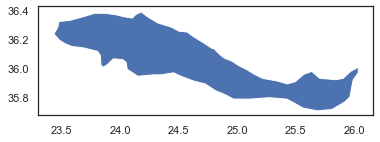

In [436]:
gpd.read_file(r'.\task2\Geospatial\Kronos_Island.shx').plot()

The Geospatial data is explored primarily in ArcGIS and PowerBI. Please see dashboard/paper for explanations with this data.

### Raw Data

In [437]:
# find files, assign to df
files = glob('task2\*.csv', recursive=True)
df = pd.DataFrame(files, columns=['Filepath'])
df['Data_name'] = df['Filepath'].apply(lambda x: x.split('\\')[-1].replace('.csv', ''))

In [440]:
# read data
df['Data'] = df['Filepath'].apply(pd.read_csv)

In [441]:
df

Filepath          Data_name  \
0    task2\car-assignments.csv    car-assignments   
1            task2\cc_data.csv            cc_data   
2                task2\gps.csv                gps   
3       task2\gps_distance.csv       gps_distance   
4       task2\loyalty_data.csv       loyalty_data   
5  task2\suspect_movements.csv  suspect_movements   

                                                Data  
0            LastName FirstName  CarID   CurrentE...  
1              timestamp             location  pr...  
2                    Timestamp  id        lat    ...  
3        Unnamed: 0   id  day  hour  minute_round...  
4        timestamp             location   price F...  
5      Unnamed: 0  id  suspect_movement  distance...

In [442]:
def lowercase_columns(df):
    df.columns = [c.lower() for c in df.columns]
    return df

def convert_to_timestamp(df):
    try:
        df['timestamp'] = df['timestamp'].astype('datetime64')
    except KeyError:
        pass
    return df

In [443]:
# fix columns, assign timestamp dtype
df['Data'] = df['Data'].apply(lowercase_columns)
df['Data'] = df['Data'].apply(convert_to_timestamp)

#### Raw Data - EDA

##### Car Assignments

The first dataset available is employee car assignments.

In [446]:
df['Data'].iloc[0].sample(5)

lastname firstname  carid currentemploymenttype currentemploymenttitle
15      Vann      Isia   16.0              Security      Perimeter Control
24  Nubarron      Adra   25.0           Engineering              Geologist
11  Cocinaro    Hideki   12.0              Security           Site Control
26    Orilla      Kare   27.0           Engineering       Drill Technician
31     Strum     Orhan   32.0             Executive                SVP/COO

In [447]:
len(df['Data'].iloc[0])

44

It contains 44 records, each with a car ID assigned to an employee, the employee's name, and job assignment.

Several cars are not assigned to individuals, but shared.

In [448]:
df['Data'].iloc[0].tail()

lastname firstname  carid currentemploymenttype currentemploymenttitle
39     Morlun   Valeria    NaN            Facilities           Truck Driver
40     Morlun      Adan    NaN            Facilities           Truck Driver
41  Morluniau   Cecilia    NaN            Facilities           Truck Driver
42       Nant     Irene    NaN            Facilities           Truck Driver
43   Scozzese     Dylan    NaN            Facilities           Truck Driver

##### CreditCard data

The next dataset contains employee credit card spending data.

In [449]:
ProfileReport(df['Data'].iloc[1])

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Each entry contains a datetimestamp, business, dollar amount and the employee name. There are 1491 records spanning from 2014-01-06 to 2014-01-19.

There are no missing values.

##### GPS data

df['Data'].iloc[2]The next dataset contains GPS data for employee vehicles.

In [450]:
df['Data'].iloc[2].dtypes

timestamp    datetime64[ns]
id                    int64
lat                 float64
long                float64
dtype: object

In [451]:
ProfileReport(df['Data'].iloc[2])

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

There are 685169 values with no missing values.

##### Loyalty data

The final dataset contains employee loyalty card transaction data, similar to the credit card dataset.

In [452]:
ProfileReport(df['Data'].iloc[3])

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Given the number of shared variables, the following joins can be made on the data.

car-assignments.name = cc_data.name

car-assignments.carid = gps.id

loyalty_data.name = cc_data.name

## Analysis

#### GPS

The distance traveled, and speed will be extracted from the GPS data to create descriptive statistics of movement patterns to help identify unusual activity.

In [453]:
def find_distance(coords1, coords2):
    try:
        return ((coords2[0]-coords1[0])**2+(coords2[1]-coords1[1])**2)**(1/2)
    except TypeError:
        return np.nan

In [454]:
gps_copy = df['Data'].iloc[2].copy()
gps_copy['coords'] = list(zip(gps_copy['lat'], gps_copy['long']))
gps_copy.sort_values(['id', 'timestamp'], inplace=True)

In [455]:
# offset timestamp and coordinates so each row has a copy of the previous coords/time
gps_copy['prev_time'] = gps_copy.groupby(['id'])['timestamp'].shift()
gps_copy['prev_coords'] = gps_copy.groupby(['id'])['coords'].shift()

In [456]:
# get distance between coordinates
gps_copy['distance'] = gps_copy.apply(lambda x: find_distance(x['coords'], x['prev_coords']), 1)

In [457]:
# get difference between timestamps
gps_copy['time_change'] = (gps_copy['timestamp'] - gps_copy['prev_time']).astype('timedelta64[s]')

In [458]:
# calculate distance/time
gps_copy['distance_per_s'] = (gps_copy['distance']/gps_copy['time_change'])

In [460]:
# get day of week and if day is on weekend
gps_copy['day_of_week'] = gps_copy['timestamp'].dt.day_of_week
gps_copy['weekend'] = gps_copy['day_of_week'].apply(lambda x: any([x == 6, x == 0]))

In [461]:
# drop infinite values, nan's
gps_copy = gps_copy[['id', 'distance', 'lat', 'long', 'timestamp', 'time_change', 'distance_per_s', 'weekend']][gps_copy['distance_per_s'] < float('inf')].dropna(axis=0)

In [462]:
gps_copy[['distance_per_s', 'weekend']].groupby(['weekend']).describe()

distance_per_s                                                        \
                 count      mean       std           min       25%       50%   
weekend                                                                        
False         542187.0  0.000098  0.000095  7.051414e-12  0.000064  0.000086   
True          140951.0  0.000098  0.000094  1.887219e-11  0.000064  0.000086   

                             
              75%       max  
weekend                      
False    0.000105  0.001671  
True     0.000105  0.001562

Luckily, it appears these employees are workaholics and do not change traveling habit based on weekday/weekend. This will make analysis easier.

The data is grouped into 15-minute segments to make analysis easier, as well as grouping with creditcard data.

In [463]:
gps_copy['day'] = gps_copy['timestamp'].dt.day
gps_copy['hour'] = gps_copy['timestamp'].dt.hour
gps_copy['minute'] = gps_copy['timestamp'].dt.minute
gps_copy['minute_round'] = gps_copy['minute'].apply(lambda x: 15*(round(x/15)))
gps_copy['coords'] = list(zip(gps_copy['lat'], gps_copy['long']))

In [464]:
gps_copy.columns

Index(['id', 'distance', 'lat', 'long', 'timestamp', 'time_change',
       'distance_per_s', 'weekend', 'day', 'hour', 'minute', 'minute_round',
       'coords'],
      dtype='object')

In [465]:
# aggregate movements within the same 15 minute chunk into a list
clean_gps = gps_copy.groupby(['id', 'day', 'hour', 'minute_round'], as_index=False)['coords', 'distance_per_s'].agg(lambda x: list(x))

<ipython-input-465-e8295f97f196>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  clean_gps = gps_copy.groupby(['id', 'day', 'hour', 'minute_round'], as_index=False)['coords', 'distance_per_s'].agg(lambda x: list(x))


This dataframe shows each employee's movement/speed by day and hour in 15-minute increments.

In [466]:
clean_gps.to_csv(r'.\task2\gps_distance.csv')

For each employee, hour, and 15-minute increment, the average position and threshold is calculated (days are excluded since employee behavior does not change based on day).

This calculation is performed only on the first 12 days, since it is assumed that there may be anomolous behaviour in the final days.

In [467]:
coords = gps_copy[gps_copy['timestamp'].dt.day < 17].groupby(['id', 'hour', 'minute_round'])['coords'].apply(list).reset_index()

In [468]:
coords['len'] = coords['coords'].apply(len)

In [ ]:
# calculate centroid of 15-minute chunk movements, and centroid std deviation
coords['centroid'] = coords['coords'].apply(lambda x: np.mean(x, axis=0))
coords['centroid_std'] = coords['coords'].apply(lambda x: np.std(x, axis=0))

This dataframe shows the aggregate 15 minutes coordinate list, the mean centroid, and the centroid std dev.

In [470]:
coords

id  hour  minute_round  \
0       1     0            15   
1       1     1            15   
2       1     3            15   
3       1     6            30   
4       1     7            15   
...   ...   ...           ...   
1385  107    17            45   
1386  107    17            60   
1387  107    18             0   
1388  107    18            15   
1389  107    18            30   

                                                 coords  len  \
0     [(36.04802716, 24.87956907), (36.04819711, 24....  196   
1     [(36.0480284, 24.8795682), (36.04819642, 24.87...  180   
2     [(36.06645565, 24.88262136), (36.06645717, 24....    2   
3                          [(36.06650603, 24.88265687)]    1   
4     [(36.06634441, 24.88258921), (36.066147, 24.88...  216   
...                                                 ...  ...   
1385  [(36.06037745, 24.87639627), (36.06032163, 24....  476   
1386  [(36.06416878, 24.84094783), (36.06410643, 24....  231   
1387  [(36.06037461, 24.87045531), (36.06034825, 24....  307   
1388  [(36.06037215, 24.8528529), (36.06035192, 24.8...  450   
1389  [(36.06037649, 24.86983965), (36.06040967, 24....  103   

                                     centroid  \
0     [36.05583816979593, 24.881602725102027]   
1      [36.05595821555554, 24.88163695655554]   
2           [36.06645641, 24.882616345000002]   
3                  [36.06650603, 24.88265687]   
4     [36.06525664689815, 24.884561712685198]   
...                                       ...   
1385  [36.061503413340354, 24.85645313827731]   
1386  [36.06098521748917, 24.853850442121225]   
1387  [36.06027674755699, 24.871025781107488]   
1388  [36.062056281822244, 24.84598323948886]   
1389   [36.06019687242718, 24.87634257611651]   

                                        centroid_std  
0     [0.0050123413725572255, 0.0012600069819552273]  
1      [0.005113761521313894, 0.0012159548688801737]  
2     [7.599999989338357e-07, 5.015000001051817e-06]  
3                                         [0.0, 0.0]  
4     [0.0006824597654726185, 0.0013228681008000077]  
...                                              ...  
1385    [0.0017531217164964222, 0.01746157113914869]  
1386    [0.0011815844700049677, 0.00973694759669654]  
1387  [0.00031009168522540915, 0.008005272657993355]  
1388   [0.0017375934241562266, 0.010628634363265405]  
1389   [0.0004098061126060178, 0.003598823284331807]  

[1390 rows x 7 columns]

A radius is calculated of 2.75 standard deviations away from this centroid. Any gps activity outside of this radius in a period would be highly unusual.

In [471]:
coords['radius'] = coords.apply(lambda x: find_distance(x['centroid'], x['centroid']+(x['centroid_std']*2.75)), axis=1)

In [473]:
gps_copy2 = clean_gps.merge(coords[['id', 'hour', 'minute_round', 'centroid', 'radius']], left_on=['id', 'hour', 'minute_round'], right_on=['id', 'hour', 'minute_round'])

Next, anomolous behaviour is found by calculating the distance of each gps ping against the expected centroid and std dev tolerance.

In [475]:
gps_copy2['distance_from_centroid'] = gps_copy2.apply(lambda x: find_distance(x['centroid'], np.mean(x['coords'], axis=0)), axis=1)

In [476]:
gps_copy2['suspect_movement'] = gps_copy2.apply(lambda x: abs(x['distance_from_centroid'])>x['radius'], axis=1)

In [477]:
len(gps_copy2[gps_copy2['suspect_movement']])

102

There are 102 extraordinary movement patterns.

In [478]:
len(gps_copy2[gps_copy2['suspect_movement']][gps_copy2['day']>=17])

<ipython-input-478-7b4b3877f9bf>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(gps_copy2[gps_copy2['suspect_movement']][gps_copy2['day']>=17])


76

76 occur in the final days leading upto the disappearances.

Looking at the ID's with the highest number of suspicious movement patterns, and the average distance from the normal location:

In [480]:
suspect_patterns = gps_copy2[gps_copy2['suspect_movement']][gps_copy2['day']>=17].groupby(['id'])['distance_from_centroid', 'suspect_movement'].agg({'suspect_movement': 'count', 'distance_from_centroid': 'mean'}).sort_values(['suspect_movement', 'distance_from_centroid'], ascending=False).reset_index().merge(df['Data'].iloc[0], left_on=['id'], right_on=['carid'])
suspect_patterns

<ipython-input-480-144216f26236>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  suspect_patterns = gps_copy2[gps_copy2['suspect_movement']][gps_copy2['day']>=17].groupby(['id'])['distance_from_centroid', 'suspect_movement'].agg({'suspect_movement': 'count', 'distance_from_centroid': 'mean'}).sort_values(['suspect_movement', 'distance_from_centroid'], ascending=False).reset_index().merge(df['Data'].iloc[0], left_on=['id'], right_on=['carid'])
<ipython-input-480-144216f26236>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  suspect_patterns = gps_copy2[gps_copy2['suspect_movement']][gps_copy2['day']>=17].groupby(['id'])['distance_from_centroid', 'suspect_movement'].agg({'suspect_movement': 'count', 'distance_from_centroid': 'mean'}).sort_values(['suspect_movement', 'distance_from_centroid'], ascending=False).reset_index().merge(df['Data'].iloc[0], left_on=['id'], right_on=['

id  suspect_movement  distance_from_centroid        lastname firstname  \
0   12                 5                0.030466        Cocinaro    Hideki   
1   13                 5                0.029681           Ferro      Inga   
2   22                 5                0.019824         Herrero     Kanon   
3   26                 5                0.019322            Onda     Marin   
4   30                 4                0.033784         Resumir     Felix   
5   24                 3                0.029379            Mies     Minke   
6   18                 3                0.026350          Frente  Birgitta   
7   17                 3                0.024608          Flecha      Sven   
8   27                 3                0.024060          Orilla      Kare   
9    4                 3                0.021803        Barranco    Ingrid   
10  35                 3                0.016035      Vasco-Pais    Willem   
11  33                 3                0.015822       Tempestad     Brand   
12  15                 3                0.015116         Bodrogi    Loreto   
13  23                 3                0.014159           Lagos     Varja   
14  25                 3                0.011916        Nubarron      Adra   
15  16                 2                0.039167            Vann      Isia   
16   7                 2                0.033760        Borrasca    Isande   
17  29                 2                0.020867            Ovan  Bertrand   
18  28                 2                0.016270          Orilla      Elsa   
19  20                 2                0.008324           Fusil    Stenig   
20  19                 2                0.004325          Frente      Vira   
21  34                 1                0.046924            Vann    Edvard   
22  14                 1                0.044370           Dedos   Lidelse   
23  10                 1                0.025159  Campo-Corrente       Ada   
24   3                 1                0.016506           Balas     Felix   
25  32                 1                0.007352           Strum     Orhan   
26   9                 1                0.005343          Calzas      Axel   

    carid   currentemploymenttype        currentemploymenttitle  
0    12.0                Security                  Site Control  
1    13.0                Security                  Site Control  
2    22.0                Security                Badging Office  
3    26.0             Engineering            Drill Site Manager  
4    30.0                Security        Security Group Manager  
5    24.0                Security             Perimeter Control  
6    18.0             Engineering                     Geologist  
7    17.0  Information Technology                 IT Technician  
8    27.0             Engineering              Drill Technician  
9     4.0               Executive                       SVP/CFO  
10   35.0               Executive  Environmental Safety Advisor  
11   33.0             Engineering              Drill Technician  
12   15.0                Security                  Site Control  
13   23.0                Security                Badging Office  
14   25.0             Engineering                     Geologist  
15   16.0                Security             Perimeter Control  
16    7.0             Engineering              Drill Technician  
17   29.0              Facilities      Facilities Group Manager  
18   28.0             Engineering              Drill Technician  
19   20.0                Security              Building Control  
20   19.0             Engineering          Hydraulic Technician  
21   34.0                Security             Perimeter Control  
22   14.0             Engineering     Engineering Group Manager  
23   10.0               Executive                       SVP/CIO  
24    3.0             Engineering                      Engineer  
25   32.0               Executive                       SVP/COO  
26    9.0             Engineering    

In the days leading up to the disappearance, security had a number of abnormal movement patters. Additionally, Ingrid Barranco and Willem Vaso-Pais, two executives, each breached their normal habit 3 times.

In [481]:
suspect_patterns.to_csv(r'.\task2\suspect_movements.csv')

#### Credit Card

The credit card data is treated similar to the GPS data. Normal spending patterns in the first 12 days are calculated, and then compared against the final 2 days.

In [482]:
cc_data = df['Data'].iloc[1].copy()

In [484]:
# create temporal groups
cc_data['day'] = cc_data['timestamp'].dt.day
cc_data['hour'] = cc_data['timestamp'].dt.hour
cc_data['minute'] = cc_data['timestamp'].dt.minute
cc_data['day_of_week'] = cc_data['timestamp'].dt.day_of_week
cc_data['minute_round'] = cc_data['minute'].apply(lambda x: 15*(round(x/15)))

In [485]:
# get employee metadata
cc_data = cc_data.merge(df['Data'].iloc[0][['carid', 'firstname', 'lastname']])

In [487]:
# group purchases into 15-minute chunks
group_cc = cc_data.groupby(['carid', 'day', 'hour', 'minute_round'], as_index=False)['price', 'location'].agg(lambda x: list(x))

<ipython-input-487-819488cea74b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  group_cc = cc_data.groupby(['carid', 'day', 'hour', 'minute_round'], as_index=False)['price', 'location'].agg(lambda x: list(x))


In [488]:
group_cc['count'] = group_cc['location'].apply(len)

In [489]:
len(group_cc[group_cc['count'] > 1])

0

Luckily, there are no more than 1 credit card expenditure in a given 15-minute window per employee, which makes analysis easier.

In [490]:
# flatten aggregate lists (just grabbing the first element since none of them are greater than len = 1)
group_cc['price'], group_cc['location'] = group_cc['price'].apply(lambda x: x[0]), group_cc['location'].apply(lambda x: x[0])

In [491]:
# convert location to category
group_cc['location'] = group_cc['location'].astype('category')
location_mapping = dict(enumerate(group_cc['location'].cat.categories))
group_cc['location'] = group_cc['location'].cat.codes

Calculating mean, std dev for spending. A range of 2.75 std dev is used to identify anomolous behavior.

In [495]:
cc_daily_stats = cc_data[cc_data['day'] < 17].groupby(['day_of_week', 'carid'], as_index=False)['price'].agg('mean').groupby(['carid'],as_index=False)['price'].agg(['mean', 'std'])

In [496]:
group_cc = group_cc.merge(cc_daily_stats, right_index=True, left_on=['carid'])

In [497]:
group_cc['suspicious'] = group_cc.apply(lambda x: x['price'] >= (x['mean'] + 2.75*x['std']) or x['price'] <= (x['mean'] - 2.75*x['std']), axis=1)

In [498]:
# adding employee metadata
group_cc = group_cc.merge(df['Data'].iloc[0], how='left')

Suspicious purchases on the 3 days prior to the disappearances:

In [502]:
group_cc['location_name'] = group_cc['location'].map(location_mapping)
group_cc_final = group_cc[group_cc['day'] >= 17][group_cc['suspicious'] == True].sort_values(['day', 'price'], ascending=False)[['firstname', 'lastname', 'day', 'hour', 'price', 'location_name', 'currentemploymenttype']]

<ipython-input-502-1e3980f8daa9>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_cc_final = group_cc[group_cc['day'] >= 17][group_cc['suspicious'] == True].sort_values(['day', 'price'], ascending=False)[['firstname', 'lastname', 'day', 'hour', 'price', 'location_name', 'currentemploymenttype']]


In [503]:
group_cc_final

firstname        lastname  day  hour   price              location_name  \
789       Adra        Nubarron   19    15  274.66     Albert's Fine Clothing   
211     Isande        Borrasca   19    20  254.29     Albert's Fine Clothing   
1037    Edvard            Vann   19    15  209.76  Frydos Autosupply n' More   
306        Ada  Campo-Corrente   19    13  190.91        Desafio Golf Course   
305        Ada  Campo-Corrente   19     3  150.36                Kronos Mart   
626     Stenig           Fusil   19    19  100.36                Guy's Gyros   
658     Hennie         Osvaldo   19    19   98.04  Frydos Autosupply n' More   
339     Gustav           Cazar   19    19   88.27                Hippokampos   
852       Kare          Orilla   19    14   54.20            Katerina�s Caf�   
433    Lidelse           Dedos   18    15  361.54  Frydos Autosupply n' More   
564   Birgitta          Frente   18    19  266.69           Roberts and Sons   
975      Orhan           Strum   18    15  258.33          Shoppers' Delight   
976      Orhan           Strum   18    18  226.49     Albert's Fine Clothing   
904   Bertrand            Ovan   18    15  177.60             General Grocer   
270       Axel          Calzas   18    15  103.55  Frydos Autosupply n' More   
269       Axel          Calzas   18    13  100.11                Hippokampos   
180     Linnea          Bergen   18    15   62.47           Roberts and Sons   
687      Kanon         Herrero   17    20  289.33          Shoppers' Delight   
54        Lars           Azada   17     8  286.24                Kronos Mart   
498       Isia            Vann   17    20  260.08  Frydos Autosupply n' More   
208     Isande        Borrasca   17    13  159.62              Chostus Hotel   
177     Linnea          Bergen   17    13  140.78            Kalami Kafenion   
562   Birgitta          Frente   17    13  108.35                Hippokampos   
368     Hideki        Cocinaro   17    20   98.03             General Grocer   

       currentemploymenttype  
789              Engineering  
211              Engineering  
1037                Security  
306                Executive  
305                Executive  
626                 Security  
658                 Security  
339              Engineering  
852              Engineering  
433              Engineering  
564              Engineering  
975                Executive  
976                Executive  
904               Facilities  
270              Engineering  
269              Engineering  
180   Information Technology  
687                 Security  
54               Engineering  
498                 Security  
208              Engineering  
177   Information Technology  
562              Engineering  
368                 Security

##### Merging GPS and CC data

In [302]:
merged_gps_cc = gps_copy2.merge(group_cc[['carid', 'day', 'hour', 'minute_round', 'price', 'location', 'suspicious']], left_on = ['id', 'day', 'hour', 'minute_round'], right_on = ['carid', 'day', 'hour', 'minute_round'], how='left')

#### Pearson's Correlation "Fingerprint"

Next, the Pearson's correlation coefficient is calculated across the data twice; once for the normal days, and once for the potentially abnormal 2 days leading up to the disappeances.

This creates a fingerprint for each employee. Deviations in normal behavior may be indicated by large changes in Pearson's r.

In [303]:
normal = merged_gps_cc[merged_gps_cc['day'] < 17]
abnormal = merged_gps_cc[merged_gps_cc['day'] >= 17]

First, the aggregate (all employee) normal correlation fingerprint:

<AxesSubplot:>

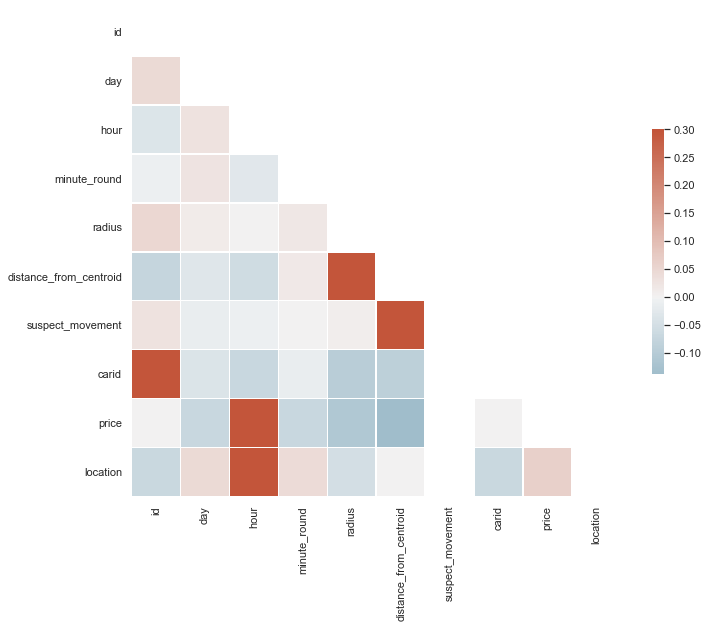

In [306]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = normal.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Abnormal aggregate correlation fingerprint:

<AxesSubplot:>

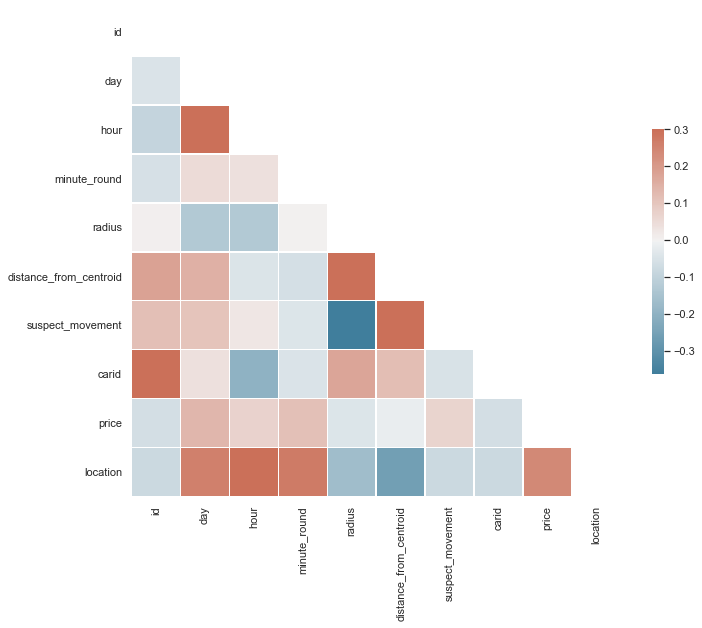

In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = abnormal.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Difference between normal and abnormal fingerprints:

<AxesSubplot:>

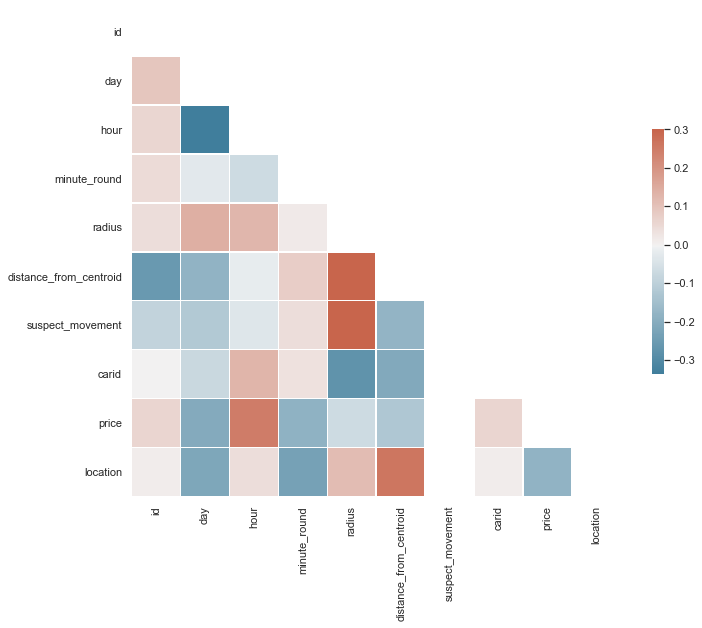

In [307]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = normal.corr() - abnormal.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

This is not very useful, but shows the underlying principals. This process is repeated for each employee.

Analysis of greatest correlation fingerprint change by employee ID:

In [342]:
# first, determine standard range of correlation fingerprint changes
corr_ranges = normal.groupby(['id', 'day']).corr().reset_index().drop(['level_2'], 1).melt(id_vars=['id', 'day']).dropna().groupby(['id', 'day'])['value'].agg(sum).reset_index().groupby(['id'])['value'].describe()

This shows the average correlation and standard deviation in the first 12 days by employee.

In [506]:
corr_ranges

count       mean       std           min       25%       50%        75%  \
id                                                                             
1     11.0   6.370521  2.125996  2.759151e+00  5.074501  6.308647   7.557040   
2     11.0   4.962291  2.395567  1.000000e+00  3.645823  4.422314   6.701814   
3     11.0   6.028674  2.822202  1.454286e+00  4.181105  5.843155   7.881061   
4     11.0   4.548973  0.924157  3.511486e+00  3.866529  4.444979   5.029424   
5     11.0   5.269724  1.840733  2.527815e+00  4.044287  4.931932   6.591180   
6     11.0   8.710453  6.815322  2.192600e+00  3.991503  5.731499  12.799847   
7     11.0   7.040738  2.025860  3.874067e+00  5.471474  7.174581   8.860710   
8     11.0   7.852706  4.873695  2.299465e+00  4.960249  6.965268   8.582125   
9      9.0   3.994944  2.202540  1.422937e+00  3.217140  3.632672   4.435778   
10    11.0   5.132239  3.157022  1.110223e-16  3.147218  4.128884   7.244080   
11    11.0   5.947336  3.334289  1.000000e+00  5.351492  5.496025   6.269027   
12    11.0  10.914622  9.050114 -2.295226e+00  5.210788  7.347138  18.495656   
13    11.0   7.645206  3.741521  3.072910e+00  5.282072  6.934858   9.010721   
14    11.0   3.265933  2.939325 -1.229208e+00  2.096741  3.343611   4.372665   
15    11.0   6.683279  6.311128 -8.754918e-01  3.539683  5.793224   7.554533   
16    11.0   6.398506  3.904122  1.123767e+00  4.891074  5.945831   7.257321   
17    11.0   6.103130  3.933641  1.861554e+00  4.115830  5.158177   6.794056   
18    10.0   3.626876  3.195417 -3.596313e+00  3.117205  4.784297   5.377535   
19    11.0   9.659809  4.706116  5.269847e+00  6.111553  7.907510  11.018386   
20    11.0  10.354939  6.208201  3.341385e+00  5.486473  7.325435  16.884659   
21    11.0   5.555480  4.003136  3.390089e-01  3.952536  4.619560   5.439606   
22    11.0   8.436967  6.796435  6.661338e-15  3.651920  5.464519  14.879404   
23    11.0   9.660972  6.011121  1.119506e+00  4.677561  9.000000  14.392418   
24    10.0  10.495059  7.665386  3.603414e+00  4.858268  8.136873  14.529902   
25    11.0   9.894345  9.370280 -9.532383e-02  3.353943  5.683838  16.584891   
26    11.0   7.174654  6.339775 -6.835140e-01  3.782751  4.553809  10.708072   
27    11.0   5.045341  2.334679  1.000000e+00  3.173436  5.984367   6.913464   
28    11.0   5.910060  2.779763  3.235695e+00  4.257686  4.422858   6.563339   
29    11.0   8.887631  7.128115  2.491004e+00  4.705797  7.256882   9.346931   
30    11.0   6.067892  1.808654  3.790439e+00  4.835712  5.535741   7.335827   
32    11.0   6.023819  2.736846  3.152899e+00  3.913571  6.090768   6.698489   
33    11.0   8.069708  5.368745  8.351940e-01  4.267713  7.517891  10.713844   
34    10.0   9.112498  4.908817  2.260990e+00  4.711069  9.099172  13.518238   
35    11.0   5.545791  1.489022  3.703589e+00  4.488799  5.448745   6.148423   
101    7.0   6.683408  1.764443  4.215542e+00  5.196662  7.417419   8.170205   
104    8.0   6.317915  1.561933  4.148119e+00  5.670951  6.317809   6.801349   
105    6.0   4.698335  1.485865  3.040769e+00  3.867422  4.376446   5.152959   
106    6.0   3.536660  1.769793  1.451073e+00  2.551727  3.381104   3.929462   
107    9.0   7.159525  2.121568  4.291742e+00  5.456595  6.241940   8.586360   

           max  
id              
1     9.848814  
2     8.787541  
3    10.093631  
4     6.626226  
5     8.094048  
6    20.092153  
7     9.531260  
8    19.025369  
9     7.863037  
10   10.366687  
11   14.615346  
12   24.936713  
13   15.868144  
14    9.769416  
15   23.649693  
16   16.000000  
17   16.545957  
18    7.311668  
19   18.574849  
20   19.909830  
21   15.758483  
22   20.265705  
23   18.757430  
24   27.293219  
25   29.098321  
26   18.405042  
27    7.608132  
28   11.755922  
29   25.380199  
30    9.292355  
32   11.404796  
33   17.228276  
34   16.162497  
35    8.848627  
101   8.417157  
104   9.170018  
105   7.286804  
106   6.619162  
107  10.378069

Next, the differences between the normal and abnormal days Peason's r is calculated.

In [345]:
fingerprint_changes = (
    (
        abs(normal.groupby(['id']).corr() - abnormal.groupby(['id']).corr()) # base corr fingerprint differences by id, absolute values only
        .reset_index()
        .drop(['level_1'], 1) # drop label column
        .melt(id_vars=['id']) # convert to key-attribute-value format
        .dropna() 
        .groupby(['id'])['value'] # regroup by id and corr fingerprint difference value
        .agg('sum') # sum differences
        .reset_index()
        .sort_values(['value'], ascending=False)
    )
    .merge(corr_ranges[['mean', 'std']], left_on=['id'], right_on=['id'])
    .merge(df['Data'].iloc[0], left_on=['id'], right_on=['carid'])
)

Finally, the individuals whose fingerprint delta is greater than 2.75 standard deviations are highlighted.

In [347]:
fingerprint_changes['significant'] = fingerprint_changes.apply(lambda x: x['value'] >= x['mean'] + 2.75*x['std'] or x['value'] <= x['mean'] - 2.75*x['std'], 1)

The following individuals all had significant correlation fingerprint changes:

In [394]:
fingerprint_final = fingerprint_changes[fingerprint_changes['significant']]

In [395]:
fingerprint_final

id      value      mean       std        lastname firstname  carid  \
0   30  31.493895  6.067892  1.808654         Resumir     Felix   30.0   
1   10  29.544628  5.132239  3.157022  Campo-Corrente       Ada   10.0   
4    2  24.687962  4.962291  2.395567           Azada      Lars    2.0   
5   16  23.239514  6.398506  3.904122            Vann      Isia   16.0   
8   32  21.302653  6.023819  2.736846           Strum     Orhan   32.0   
9   35  21.214400  5.545791  1.489022      Vasco-Pais    Willem   35.0   
10   4  21.045033  4.548973  0.924157        Barranco    Ingrid    4.0   
11   7  20.118574  7.040738  2.025860        Borrasca    Isande    7.0   
15   3  17.418496  6.028674  2.822202           Balas     Felix    3.0   
19   1  15.227954  6.370521  2.125996         Alcazar     Lucas    1.0   
22   5  12.005453  5.269724  1.840733            Baza      Isak    5.0   

     currentemploymenttype        currentemploymenttitle  significant  
0                 Security        Security Group Manager         True  
1                Executive                       SVP/CIO         True  
4              Engineering                      Engineer         True  
5                 Security             Perimeter Control         True  
8                Executive                       SVP/COO         True  
9                Executive  Environmental Safety Advisor         True  
10               Executive                       SVP/CFO         True  
11             Engineering              Drill Technician         True  
15             Engineering                      Engineer         True  
19  Information Technology                   IT Helpdesk         True  
22  Information Technology                 IT Technician         True

#### Loyalty data

Finally, the differences between the reported loyalty amounts and the actual credit card spend amounts is analyzed.

In [349]:
# Get day and merge with CC data
loyalty_data = df['Data'].iloc[3].copy()
loyalty_data['day'] = loyalty_data['timestamp'].dt.day
merged_spending = cc_data.drop(['timestamp'], 1).merge(loyalty_data.drop(['timestamp'], 1), left_on=['firstname', 'lastname', 'location', 'day'], right_on=['firstname', 'lastname', 'location', 'day'])

In [374]:
# calculate differences
merged_spending['diff'] = merged_spending['price_x'] - merged_spending['price_y']

In [375]:
merged_spending = merged_spending[merged_spending['diff'] > 0]

In [376]:
merged_spending

location  price_x firstname  lastname  day  hour  \
3              Brew've Been Served    32.30    Edvard      Vann    8     8   
8              Brew've Been Served    97.25    Edvard      Vann   10     7   
9                      Hippokampos    79.26    Edvard      Vann   10    13   
15                    Ouzeri Elian    95.03    Edvard      Vann   13    13   
29                Hallowed Grounds    52.22    Hideki  Cocinaro    6     7   
...                            ...      ...       ...       ...  ...   ...   
1084         Carlyle Chemical Inc.  1392.73   Valeria    Morlun   15    17   
1090         Carlyle Chemical Inc.  1814.24   Valeria    Morlun   16    17   
1100                 Abila Airport  3379.21     Dylan  Scozzese   14    13   
1117  Stewart and Sons Fabrication  4545.38      Adan    Morlun   15    11   
1119           Nationwide Refinery  2302.73   Claudio   Hawelon   10    10   

      minute  minute_round  carid  day_of_week  price_y     diff  
3          0             0   34.0            2    12.30    20.00  
8         56            60   34.0            4    17.25    80.00  
9         20            15   34.0            4    39.26    40.00  
15        37            30   34.0            0    35.03    60.00  
29        34            30   12.0            0    12.22    40.00  
...      ...           ...    ...          ...      ...      ...  
1084       1             0    NaN            2  1112.04   280.69  
1090      17            15    NaN            3   419.93  1394.31  
1100       6             0    NaN            1  3339.21    40.00  
1117      18            15    NaN            2  4485.38    60.00  
1119      40            45    NaN            4  2262.73    40.00  

[239 rows x 12 columns]

Employees misreported their loyalty data 239 times. Most of these are probably mistakes, so a 1x standard deviation is used to highlight only those with statistical significance.

Std dev and mean are based on the descriptive statistics of the spend **location** (e.g. how much people tend to over/under report at the grocery store).

In [377]:
merged_spending = merged_spending.merge(merged_spending.groupby(['location'])['diff'].describe()[['mean', 'std']], left_on='location', right_index=True)

In [386]:
merged_spending['suspect'] = merged_spending.apply(lambda x: x['diff'] >= (x['mean'] + x['std']) or x['diff'] <= (x['mean'] - x['std']), axis=1)

In [392]:
merged_spending_final = merged_spending[merged_spending['day'] >= 17][['location', 'price_x', 'diff', 'firstname', 'lastname', 'day']].sort_values(['price_x', 'day'], ascending=[0, 1]).merge(df['Data'].iloc[0])

In [393]:
merged_spending_final

location  price_x   diff firstname        lastname  day  \
0   Frydos Autosupply n' More   361.54  80.00   Lidelse           Dedos   18   
1           Shoppers' Delight   289.33  20.00     Kanon         Herrero   17   
2         Brew've Been Served    51.04  40.00     Kanon         Herrero   17   
3               Chostus Hotel   159.62  40.00    Isande        Borrasca   17   
4           Brewed Awakenings    88.69  80.00    Isande        Borrasca   17   
5                 Hippokampos   108.35  80.00  Birgitta          Frente   17   
6             Kalami Kafenion   105.32  80.00    Willem      Vasco-Pais   17   
7                 Guy's Gyros   100.36  60.00    Stenig           Fusil   19   
8                 Hippokampos   100.11  80.00      Axel          Calzas   18   
9                 Hippokampos    29.21   9.10      Axel          Calzas   18   
10                Hippokampos    21.81  11.67      Axel          Calzas   17   
11             General Grocer    98.03  20.00    Hideki        Cocinaro   17   
12              Abila Zacharo    79.67  40.00      Isia            Vann   17   
13            Katerina�s Caf�    72.25  60.00  Bertrand            Ovan   19   
14            Katerina�s Caf�    72.13  40.00      Nils         Calixto   17   
15            Kalami Kafenion    71.14  60.00     Felix           Balas   18   
16               Ouzeri Elian    70.21  60.00      Elsa          Orilla   17   
17              Abila Zacharo    68.78  60.00       Ada  Campo-Corrente   17   
18               Ouzeri Elian    61.56  40.00     Lucas         Alcazar   18   
19                Guy's Gyros    55.40  40.00     Minke            Mies   17   
20                Guy's Gyros    55.21  23.73      Sven          Flecha   18   
21        Brew've Been Served    52.56  40.00      Sven          Flecha   17   
22                Guy's Gyros    39.14  30.60    Loreto         Bodrogi   17   
23           Hallowed Grounds    38.22  20.00      Kare          Orilla   17   
24                Guy's Gyros    37.55  15.37     Varja           Lagos   17   
25                Guy's Gyros    32.31  15.48     Felix         Resumir   17   

    carid   currentemploymenttype        currentemploymenttitle  
0    14.0             Engineering     Engineering Group Manager  
1    22.0                Security                Badging Office  
2    22.0                Security                Badging Office  
3     7.0             Engineering              Drill Technician  
4     7.0             Engineering              Drill Technician  
5    18.0             Engineering                     Geologist  
6    35.0               Executive  Environmental Safety Advisor  
7    20.0                Security              Building Control  
8     9.0             Engineering              Drill Technician  
9     9.0             Engineering              Drill Technician  
10    9.0             Engineering              Drill Technician  
11   12.0                Security                  Site Control  
12   16.0                Security             Perimeter Control  
13   29.0              Facilities      Facilities Group Manager  
14    8.0  Information Technology                 IT Technician  
15    3.0             Engineering                      Engineer  
16   28.0             Engineering              Drill Technician  
17   10.0               Executive                       SVP/CIO  
18    1.0  Information Technology                   IT Helpdesk  
19   24.0                Security             Perimeter Control  
20   17.0  Information Technology                 IT Technician  
21   17.0  Information Technology                 IT Technician  
22   15.0                Security                  Site Control  
23   27.0             Engineering              Drill Technician  
24   23.0                Security                Badging Office  
25   30.0                Security        Security Group Manager

### Results

The 3 treatments are combined to show the individuals found most frequently across treatments, and those with the most aggregate anomolous behavior, regardless of treatment.

In [414]:
final_counts = merged_spending_final.groupby(['firstname', 'lastname'], as_index=False)['price_x'].count().merge(group_cc_final.groupby(['firstname', 'lastname'], as_index=False)['price'].count(), how='outer').merge(suspect_patterns.groupby(['firstname', 'lastname'], as_index=False)['suspect_movement'].sum(), how='outer')

In [421]:
final_counts['n_treatments'] = 3-final_counts.isnull().sum(axis=1)

In [427]:
final_counts['n_suspicious_hits'] = final_counts['price_x'].fillna(0) + final_counts['price'].fillna(0) + final_counts['suspect_movement'].fillna(0)

In [433]:
final_counts[['firstname', 'lastname', 'n_treatments', 'n_suspicious_hits']].sort_values(['n_treatments', 'n_suspicious_hits'], ascending=False).merge(df['Data'].iloc[0].drop(['carid'], 1))

firstname        lastname  n_treatments  n_suspicious_hits  \
0      Kanon         Herrero             3                8.0   
1     Hideki        Cocinaro             3                7.0   
2       Axel          Calzas             3                6.0   
3   Birgitta          Frente             3                6.0   
4     Isande        Borrasca             3                6.0   
5       Kare          Orilla             3                5.0   
6        Ada  Campo-Corrente             3                4.0   
7   Bertrand            Ovan             3                4.0   
8       Isia            Vann             3                4.0   
9     Stenig           Fusil             3                4.0   
10   Lidelse           Dedos             3                3.0   
11     Felix         Resumir             2                5.0   
12      Sven          Flecha             2                5.0   
13    Loreto         Bodrogi             2                4.0   
14     Minke            Mies             2                4.0   
15     Varja           Lagos             2                4.0   
16    Willem      Vasco-Pais             2                4.0   
17      Adra        Nubarron             2                4.0   
18      Elsa          Orilla             2                3.0   
19     Orhan           Strum             2                3.0   
20     Felix           Balas             2                2.0   
21    Edvard            Vann             2                2.0   
22      Inga           Ferro             1                5.0   
23     Marin            Onda             1                5.0   
24     Brand       Tempestad             1                3.0   
25    Ingrid        Barranco             1                3.0   
26    Linnea          Bergen             1                2.0   
27      Vira          Frente             1                2.0   
28     Lucas         Alcazar             1                1.0   
29      Nils         Calixto             1                1.0   
30    Gustav           Cazar             1                1.0   
31    Hennie         Osvaldo             1                1.0   
32      Lars           Azada             1                1.0   

     currentemploymenttype        currentemploymenttitle  
0                 Security                Badging Office  
1                 Security                  Site Control  
2              Engineering              Drill Technician  
3              Engineering                     Geologist  
4              Engineering              Drill Technician  
5              Engineering              Drill Technician  
6                Executive                       SVP/CIO  
7               Facilities      Facilities Group Manager  
8                 Security             Perimeter Control  
9                 Security              Building Control  
10             Engineering     Engineering Group Manager  
11                Security        Security Group Manager  
12  Information Technology                 IT Technician  
13                Security                  Site Control  
14                Security             Perimeter Control  
15                Security                Badging Office  
16               Executive  Environmental Safety Advisor  
17             Engineering                     Geologist  
18             Engineering              Drill Technician  
19               Executive                       SVP/COO  
20             Engineering                      Engineer  
21                Security             Perimeter Control  
22                Security                  Site Control  
23             Engineering            Drill Site Manager  
24             Engineering              Drill Technician  
25               Executive                       SVP/CFO  
26  Information Technology              IT Group Manager  
27             Engineering          Hydraulic Technician  
28  Information Technology                   IT Helpdesk  
29  Information Techno

This final analysis shows that Kanon Herrero was identified with suspicious behavior across all 3 treatments, totallying 8 hits across all treatments (multiple hits per treatment). The executive Ada Campo-Corrente was also found across all 3 treatments.

In [504]:
final_counts[['firstname', 'lastname', 'n_treatments', 'n_suspicious_hits']].sort_values(['n_treatments', 'n_suspicious_hits'], ascending=False).merge(df['Data'].iloc[0].drop(['carid'], 1)).to_csv('final_counts.csv')